In [12]:
from configparser import ConfigParser, ExtendedInterpolation

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from spikelib.fitting import gaussian2d
from spikelib.utils import check_groups

%matplotlib notebook
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

['../../config.ini']

In [117]:
def fit_sta_2d(data_raw):
    (_, y_shape, x_shape) = data_raw.shape
    (frame, y0, x0) = np.unravel_index(np.abs(data_raw).argmax(), data_raw.shape)
    z0 = data_raw[frame, y0, x0]
    data = data_raw[frame]

    x = np.linspace(0, x_shape - 1, x_shape)
    y = np.linspace(0, y_shape - 1, y_shape)
    x, y = np.meshgrid(x, y)
    # (xy, amp, x0, y0, sigma_x, sigma_y, theta, offset, revel=True):
    initial_guess = (z0, x0, y0, 1, 1, 1.5, 0)
    popt, pcov = opt.curve_fit(gaussian2d, (x.ravel(), y.ravel()), np.sign(z0)*data.ravel(), p0=initial_guess)
    
    return popt, pcov, frame


def truncate_center(number, constrains):
    """Set a min and max value for a number.
    
    Parameters
    ----------
    number: float
        any number to truncate
    constrains: list
        min and max value
    
    Return
    ------
    value: flaot
    
    """
    min_value, max_value = constrains
    if number < min_value:
        new_number = min_value 
    elif number > max_value:
        new_number = max_value - 1
    else:
        new_number = number
    
    return new_number

def sta_fitting_2d(file_name, intensity):
    with h5py.File(file_name, 'r+') as h5file:
        unit_names = list(h5file[f'/sta/{intensity}/raw/'].keys())
        (frames, y_shape, x_shape) = h5file[f'/sta/{intensity}/raw/' + unit_names[0]].shape

        x = np.linspace(0, x_shape - 1, x_shape)
        y = np.linspace(0, y_shape - 1, y_shape)
        xy = np.meshgrid(x,y)

        rawsta_group = f'/sta/{intensity}/raw/'
        temp_group = f'/sta/{intensity}/temporal/'
        temp_raw_group = temp_group + 'raw/'
        spacial_group = f'/sta/{intensity}/spatial/char/'


        check_groups(h5file, [temp_raw_group, spacial_group])      

        for kunit in unit_names:
            raw_sta = h5file[f'/sta/{intensity}/raw/' + kunit][:]
            popt, pcov, frame = fit_sta_2d(raw_sta)
            (amp, x0, y0, sigma_x, sigma_y, theta, offset) = popt

            data = raw_sta[frame]
            y_0 = int(np.floor(truncate_center(y0, [0, y_shape])))
            x_0 = int(np.floor(truncate_center(x0, [0, x_shape])))
            raw_temp = raw_sta[:, y_0, x_0]        
            snr = (raw_sta[:, y_0, x_0].var() / raw_sta.var(axis=0).mean())
            spatial_params = (theta, sigma_x, sigma_y, x0, y0, snr , frame)
            print(spatial_params)

            if kunit in h5file[temp_raw_group]:
                h5file[temp_raw_group + kunit][...] = raw_temp
            else:
                h5file[temp_raw_group].create_dataset(kunit, data=raw_temp, dtype=np.float)

            if kunit in h5file[spacial_group]:
                h5file[spacial_group + kunit][...] = spatial_params
            else:
                h5file[spacial_group].create_dataset(kunit, data=spatial_params, dtype=np.float)            

        h5file[temp_raw_group].attrs['time'] = h5file[rawsta_group].attrs['time']
        h5file[temp_raw_group].attrs['nsamples_before'] = h5file[rawsta_group].attrs['nsamples_before']
        h5file[temp_raw_group].attrs['nsamples_after'] = h5file[rawsta_group].attrs['nsamples_after']
        h5file[temp_raw_group].attrs['fps'] = h5file[rawsta_group].attrs['fps']
        h5file[temp_raw_group].attrs['nsamples'] = h5file[rawsta_group].attrs['nsamples']
        h5file[spacial_group].attrs['col_name'] = 'angle,a,b,x,y,snr,frame'


In [72]:
# Parameters
events_file = config['SYNC']['events']
processed_file = config['FILES']['processed']
protocol_name = config['CHECKERBOARD']['protocol_name']

df = pd.read_csv(events_file)
checkerboard_times = df[df['protocol_name'] == protocol_name]

In [115]:
for event in checkerboard_times.itertuples():
    # Sync
    intensity = '{}-{}'.format(event.nd, int(event.intensity))
    print('Computing fitting to {}'.format(intensity))
    
    sta_fitting_2d(processed_file, intensity)

Computing fitting to nd3-255
(-14975723.52152435, 0.24654943997432593, 1.2127845307193983, 19.35736874535088, 2.366156382431624, 1.0772057620835356, 15)
(159576619.87387228, 0.3721396441457217, 0.3647300468583571, 7.039268490235859, 26.272462955934508, 1.3813399450256856, 7)
(27102771.071846813, 1.0272364446704545, 0.6592085647407174, 25.276917113405762, 17.376292525234682, 1.3046862700427106, 24)
(19872223.976396218, -0.7314993695610754, 0.3450325055858542, 1.0734245609946462, 0.2213020032115453, 1.4305557278813301, 17)
(-75032342.35085645, 0.13522216658386116, 0.6800114715442809, 7.892930208503125, 1.0770051518954136, 0.8539985248276238, 2)
(-16151572.78331357, 0.17447960737087165, 0.08264293075148965, 5.023447267522687, 25.994480135015827, 0.9893299988654463, 16)
(16289428.13773094, 0.20197494616820955, 0.44941578939368637, 2.0336349476735243, 21.286355868167565, 1.093617772811937, 23)
(13694888.649497518, 0.19027312077885278, 0.31355033846535196, 29.16408940734817, 8.00364631458167

(-116369480.87643981, 0.36680728591859524, 1.694275302363514, 13.257058333857415, 4.943486153134038, 1.0149274835990179, 13)
(-15384976.144532794, 0.2285599674829524, -0.12678879718021513, 5.023195112072967, 16.05763344675298, 1.3203568216277077, 3)
(8510908.40046686, 0.1837410849301614, 0.7541346297171525, 20.307691881632923, 9.716069356038956, 0.9970515239253513, 29)
(-32852866.654162858, -0.8086140740782958, -0.1912379403507143, 28.43190976999727, 2.936005855584686, 0.9991439684415758, 3)
(72738301.84334792, 0.6028650911324628, -0.025389124742565113, 23.967519070564386, 12.123337268288743, 1.1412605362177575, 5)
(8344864.56076847, 1.4752092108566264, 0.18020017630616247, 26.40724156143753, 2.1314937321727734, 1.0831885339604317, 2)
(3497065.9917653957, 0.25895374254700204, 0.7378276852541096, 0.3054942439959167, 16.676214256050304, 1.1042083027104848, 26)
(21513712.458951555, 0.31875461365899743, 0.5118208195785912, 12.721421342688918, 7.040106165747362, 1.0554278480739976, 15)
(202

(54979267.069312856, 0.40182172700378016, 0.06676210877497936, 14.844800220465427, 2.864369815006993, 0.8989863237885487, 8)
(-70791408.87542412, 0.24483171810781917, 0.65673362799141, 17.01556134906479, 26.288014619189774, 1.3111333485201606, 4)
(5277740.432988587, 1.5397400221708115, 1.7688900272105905, 3.214741473457418, 15.626185589816066, 3.151517037407921, 25)
(14852039.738540944, 1.5422091282334325, 0.6810581218028067, 5.8190009433217655, 31.09956351352796, 0.9690712345050957, 28)
(-157860459.2596741, 0.21215535555529197, 1.045257415037705, 28.30834161245709, 3.009376124794794, 1.1424325245404479, 1)
(-34558998.12739169, 0.6221845088387106, 1.4306529981785479, 11.766178270135695, 20.82854361572116, 1.542817860522299, 23)
(63862514.275195144, 0.1419044277443739, 0.5655833732835986, 15.103882891740458, 14.042052726478246, 1.2235350138818972, 8)
(-33602106.90743597, 0.48376260887199013, 0.5094498575107341, 5.956073208026883, 11.708560523470844, 0.9357420310952453, 22)
(18955597.311

(-31388118.82239013, 2.064548196512674, 1.3945242625352652, -0.9531429376217907, 9.070808940646113, 6.434154330172334, 25)
(139107638.68359226, 0.3946280804699775, 0.3765384094212223, 6.861174178370725, 15.847306189847206, 0.8721582811173181, 11)
(63939375.74453892, 0.4437100775419319, 0.3304519408157307, 20.0894634548688, 13.169523031385394, 1.5032336262201822, 20)
(-36549882.758822955, -0.45515223923002174, 1.240255959167814, 17.73583330769491, 10.631254791283695, 0.9344956457045861, 12)
(-100580390.07072054, 5.99693430555661, -2.4960588368627112, 0.9986070627066056, 7.373882027787856, 0.9466883844065852, 8)
(104014645.54521076, 0.1519543955656067, -0.4665996866689066, 10.955879364259367, 0.5475519825559274, 0.9324331656525122, 18)
(180439806.35710993, 0.9982467558955921, 0.22370807812018698, 17.87606948196352, 25.921070171774023, 1.0044482278803541, 29)
(19001073.336491093, 1.088562818592742, 0.7492052459690418, 0.2536387214442308, 23.077989072478793, 2.054885102279236, 25)
(-417525

(89433183.27721332, -0.2954737055333525, 7.087961868189401, -1.7655296632215567, 27.761340356905453, 1.3666244102119527, 21)


In [107]:
with h5py.File(ffile, 'r') as h5file:
    raw_temp = h5file[f'/sta/{intensity}/temporal/raw/']
    raw_char = h5file[f'/sta/{intensity}/spatial/char/']
    temp_char = np.array([raw_temp[kunit][:] for kunit in raw_temp])
    spatial_char = np.array([raw_char[kunit][:] for kunit in raw_char])
    

<IPython.core.display.Javascript object>


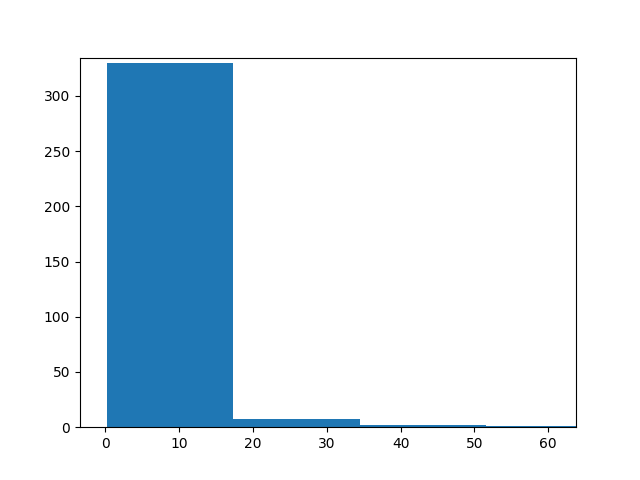

(array([330.,   7.,   2.,   1.,   1.,   1.,   3.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.88341515e-01, 1.73246853e+01, 3.44610290e+01, 5.15973727e+01,
        6.87337165e+01, 8.58700602e+01, 1.03006404e+02, 1.20142748e+02,
        1.37279091e+02, 1.54415435e+02, 1.71551779e+02, 1.88688123e+02,
        2.05824466e+02, 2.22960810e+02, 2.40097154e+02, 2.57233498e+02,
        2.74369841e+02, 2.9150

In [123]:
f, ax = plt.subplots()
ax.hist(spatial_char[:,-2], bins=100)

<IPython.core.display.Javascript object>


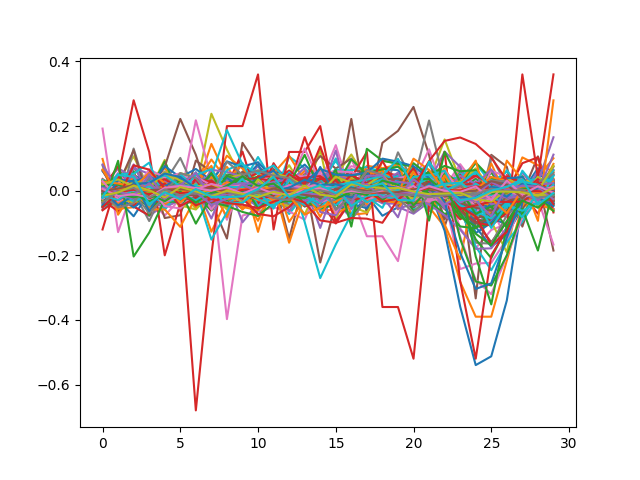

In [75]:
f, ax = plt.subplots()
ax.plot(temp_char.T);

<IPython.core.display.Javascript object>


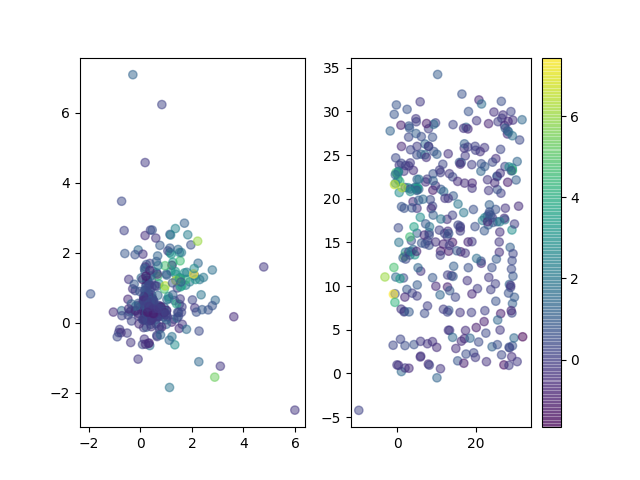

In [134]:
f, ax = plt.subplots(1,2)
cc = ax[0].scatter(spatial_char[:, 1], spatial_char[:, 2], c=np.log(spatial_char[:, -2]), alpha=0.5)
cc = ax[1].scatter(spatial_char[:, 3], spatial_char[:, 4], c=np.log(spatial_char[:, -2]), alpha=0.5)
f.colorbar(cc)

<IPython.core.display.Javascript object>


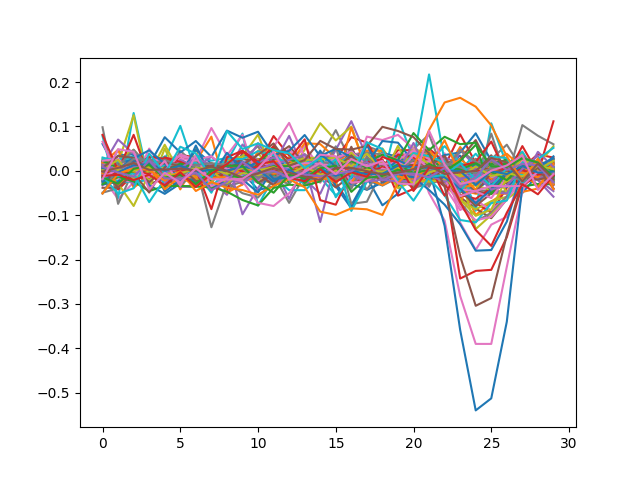

In [132]:
f, ax = plt.subplots()
ax.plot(temp_char[(spatial_char[:, -1] > 15) & (spatial_char[:, -1] <25), :].T);

[ 8.27194878e-02  1.93573687e+01  2.36615638e+00  2.46549440e-01
  1.21278453e+00 -1.49757235e+07  6.08342070e-04]
19 2
[ 1.91266555e-01  7.03926849e+00  2.62724630e+01  3.72139644e-01
  3.64730047e-01  1.59576620e+08 -1.89596668e-03]
7 26
[9.32628488e-02 2.52769171e+01 1.73762925e+01 1.02723644e+00
 6.59208565e-01 2.71027711e+07 2.71350333e-04]
25 17
[ 2.76649402e-02  1.07342456e+00  2.21302003e-01 -7.31499370e-01
  3.45032506e-01  1.98722240e+07 -8.51258661e-05]
1 0
[ 4.56161541e-02  7.89293021e+00  1.07700515e+00  1.35222167e-01
  6.80011472e-01 -7.50323424e+07 -1.83765120e-04]
7 1
[ 3.61243439e-02  5.02344727e+00  2.59944801e+01  1.74479607e-01
  8.26429308e-02 -1.61515728e+07  3.88073578e-04]
5 25
[9.38023553e-02 2.03363495e+00 2.12863559e+01 2.01974946e-01
 4.49415789e-01 1.62894281e+07 6.89247221e-05]
2 21
[4.02948849e-02 2.91640894e+01 8.00364631e+00 1.90273121e-01
 3.13550338e-01 1.36948886e+07 1.25627541e-04]
29 8
[ 1.63918178e-02  1.89507847e+01  2.12093044e+01 -3.78205837e-

/home/vnc/anaconda3/envs/spkdev/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[ 9.20536859e-02  1.00636339e+01 -4.91281507e-01  3.28925732e-01
  6.00189361e-01  3.53266188e+07 -4.34311574e-04]
10 -1
[8.43398235e-02 6.92747072e+00 6.88077949e+00 6.97189005e-01
 4.95679802e-01 1.56923029e+07 3.61866679e-05]
6 6
[ 2.58137733e-02  2.91574202e+01  3.16869732e+00 -1.93733147e+00
  8.24999305e-01 -6.81411850e+07 -7.01552149e-04]
29 3
[ 4.67522563e-02  4.52207600e+00  2.13096776e+01  2.23794231e+00
  1.70160387e+00 -3.58716536e+05  8.84976058e-04]
4 21
[4.11019209e-02 1.80387453e+01 2.99881759e+01 4.37274177e-02
 3.54034652e-01 3.70399627e+07 1.06605810e-04]
18 29
[ 3.83516360e-02  8.38731855e+00  1.98949262e+01  3.76608844e-01
  9.20154172e-01  6.32188606e+07 -2.30665042e-04]
8 19
[ 4.61077269e-02  5.08230527e+00  1.01373846e+01  2.95446072e-01
  8.54844314e-01 -9.10184999e+07  5.02074952e-04]
5 10
[ 2.34710436e-02  1.59149280e+01  6.98081208e+00  2.31054254e-01
  3.59960248e-01  1.74614823e+08 -9.01286078e-05]
15 6
[ 2.10121311e-01  1.85408609e+00  1.34182100e+01  2.8

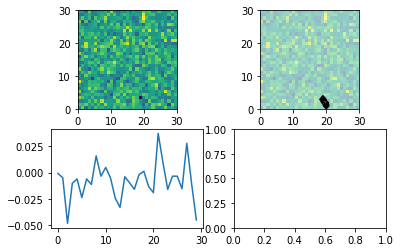

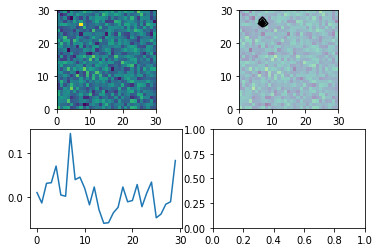

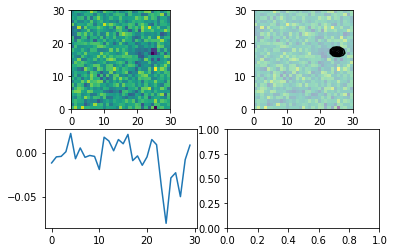

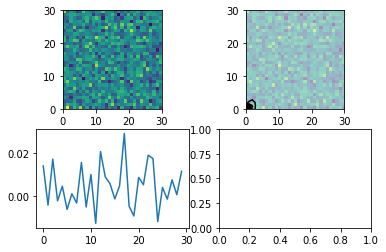

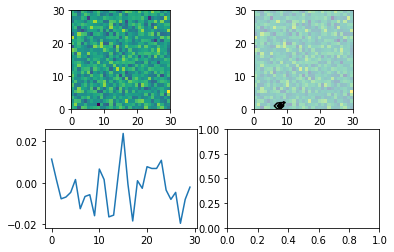

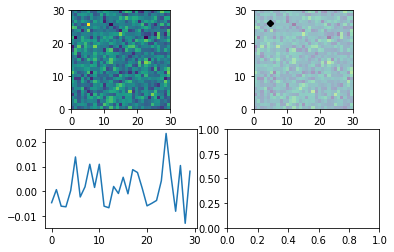

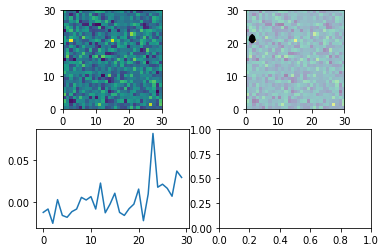

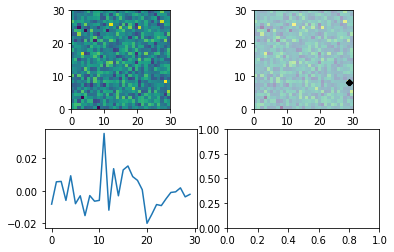

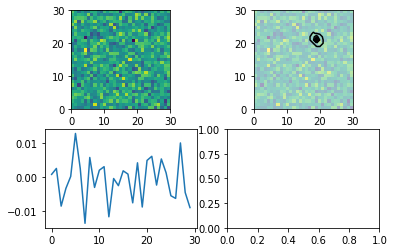

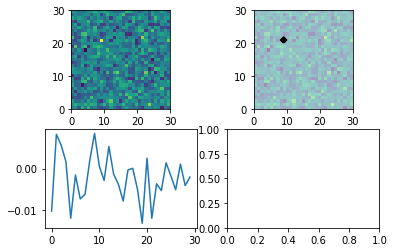

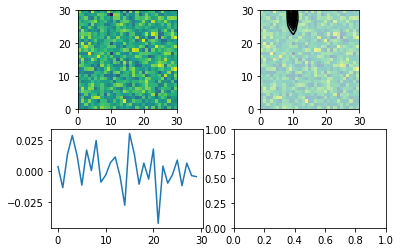

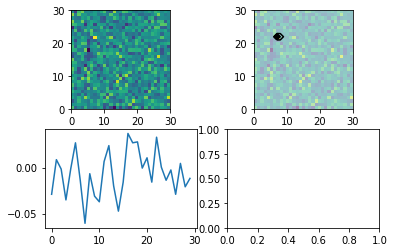

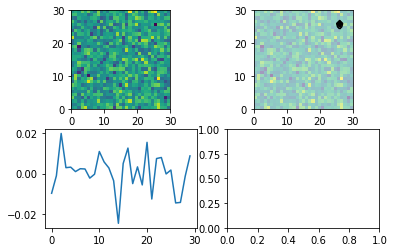

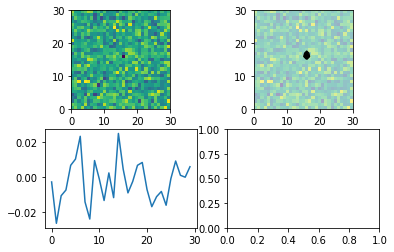

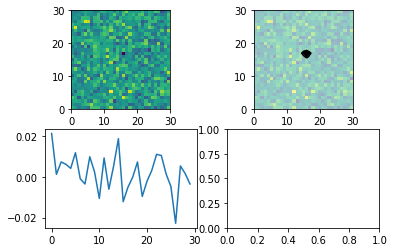

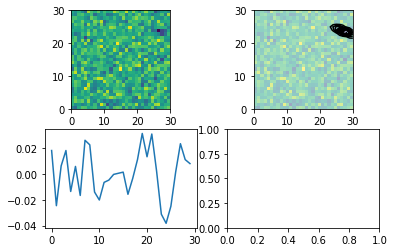

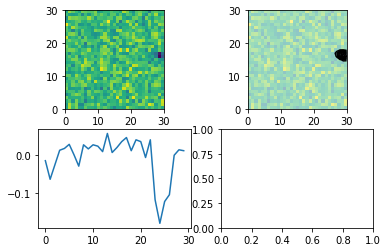

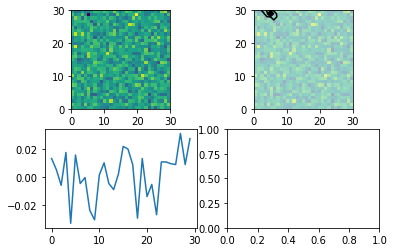

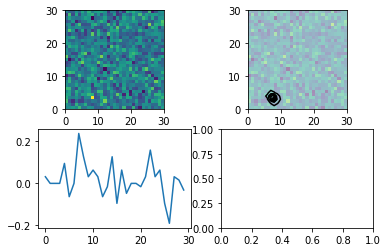

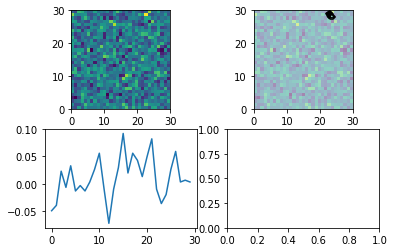

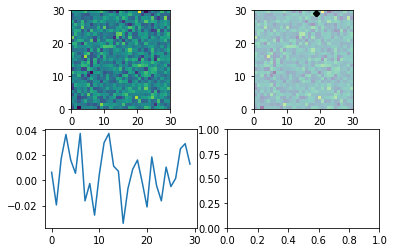

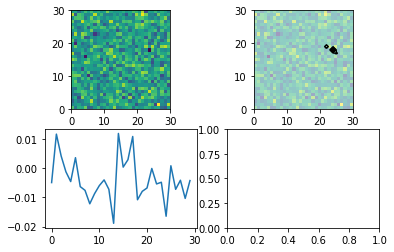

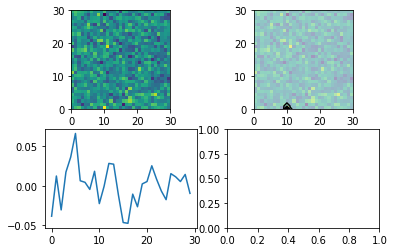

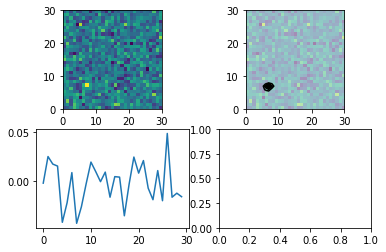

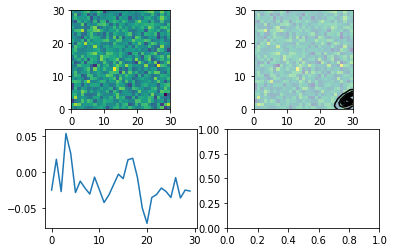

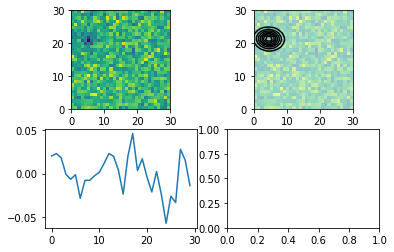

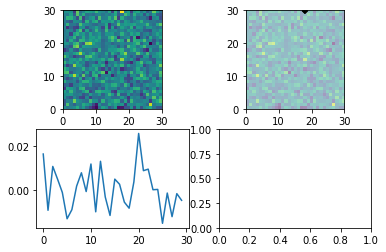

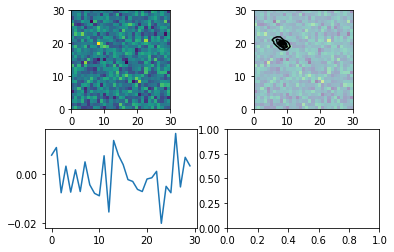

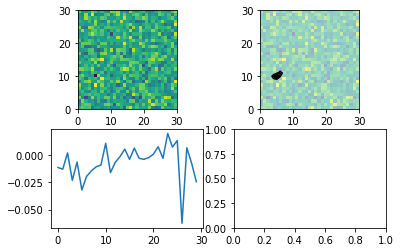

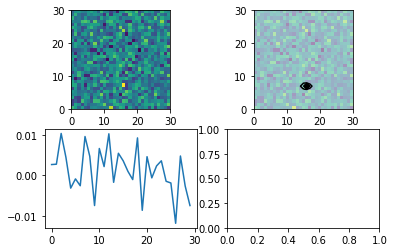

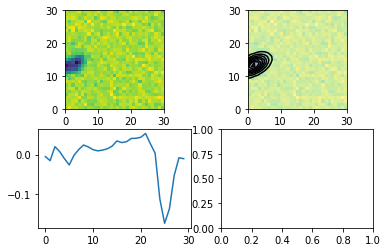

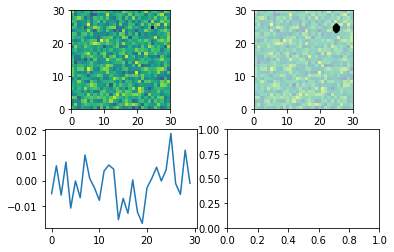

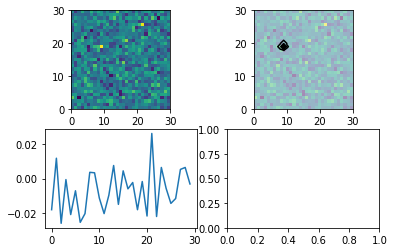

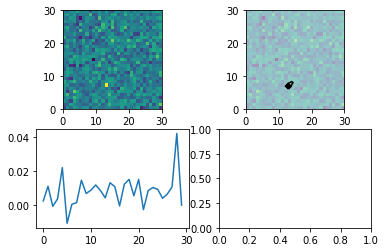

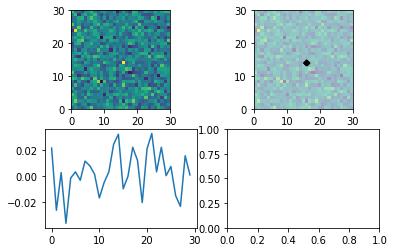

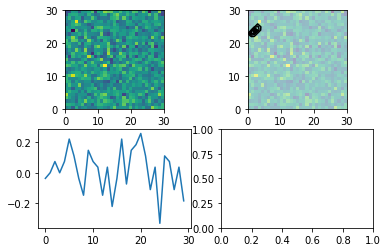

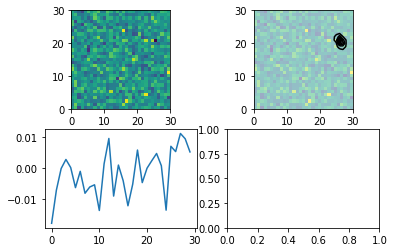

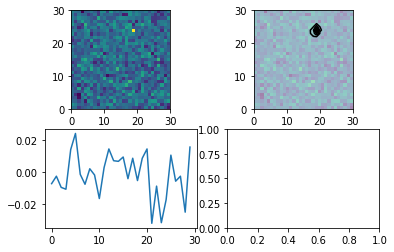

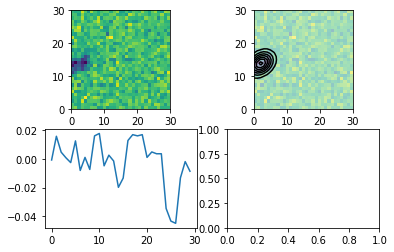

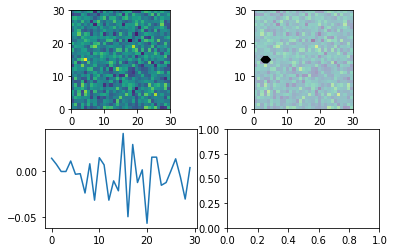

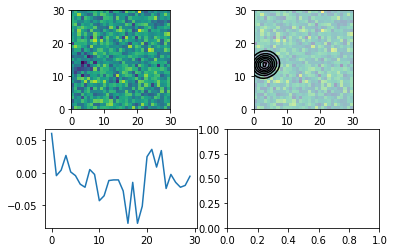

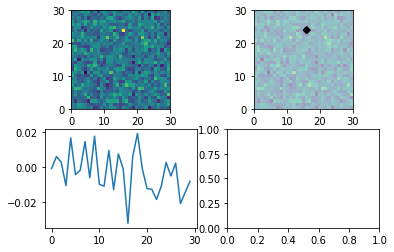

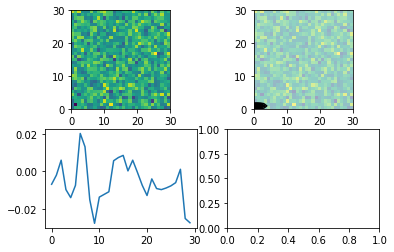

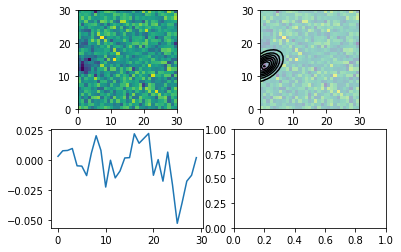

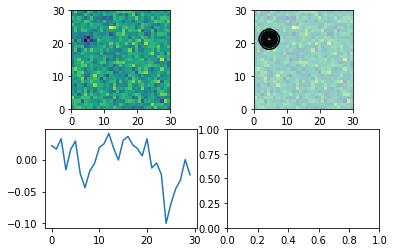

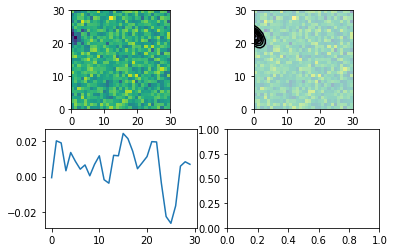

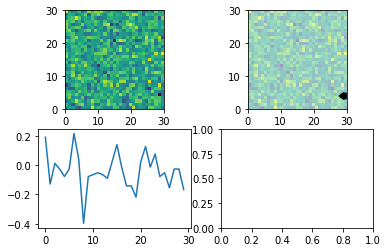

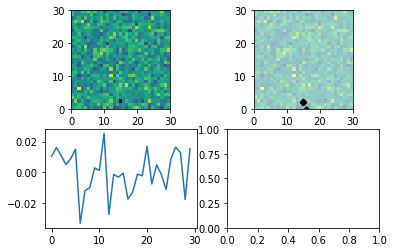

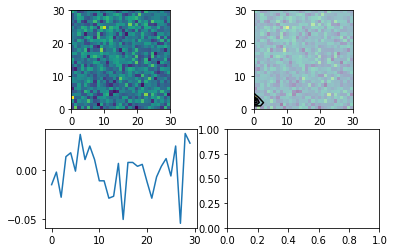

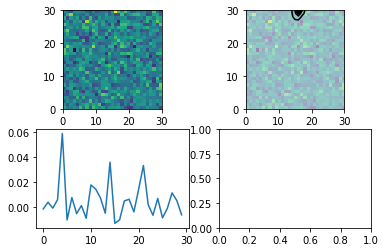

In [36]:
# def plot_sta_contour(stas_array, popt)
#     z_shape, y_shape, x_shape = stas_array.shape
#     x = np.linspace(0, x_shape - 1, x_shape)
#     y = np.linspace(0, y_shape - 1, y_shape)
#     xy = np.meshgrid(x,y)

#     (amp, x0, y0, sigma_x, sigma_y, theta, offset) = popt

#     data = stas_array[idx, frame]
#     print(popt)
#     y_0 = int(np.floor(y0)) if y0 < 31 else 30
#     x_0 = int(np.floor(x0)) if x0 < 31 else 30
#     print(x_0, y_0)
#     sta_raw = stas_array[idx, :, y_0, x_0]
#     data_fitted = gaussian2d(xy, *popt)

#     fig, ax = plt.subplots(2, 2, sharex=False, sharey=False)
#     ax[0, 0].imshow(data, cmap=plt.cm.viridis, origin='bottom', extent=(x.min(), x.max(), y.min(), y.max()))
#     ax[0, 1].imshow(data, cmap=plt.cm.viridis, origin='bottom', extent=(x.min(), x.max(), y.min(), y.max()), alpha=0.5)
#     ax[0, 1].contour(x, y, data_fitted.reshape(y_shape, x_shape), 8, colors='k')
#     ax[1, 0].plot(sta_raw)
